<a href="https://colab.research.google.com/github/unica-ml/ml/blob/master/notebooks/gauss_clf_exercise_with2d_error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gaussian Classifier: Bonus Exercise

Consider a Gaussian classifier, which makes decisions as:

$y_k^\star = \arg\max_{y_k} p(y_k | x ) = \frac{p(x|y_k) p_k}{p(x)},$

being $p_k$ the prior probability of class $y_k$, while the likelihood $p(x | y_k)$ is estimated as:

$$p(x | y_k) = \mathrm{g}(x ; \mu_k, \Sigma_k)=\frac{1}{\sqrt{(2 \pi)^{d} \operatorname{det} \Sigma_k}} \exp \left(-\frac{1}{2}(x-\mu_k)^{T} \Sigma_k^{-1}(x-\mu_k)\right).$$

Recall that the evidence $p(x)$ can be computed by marginalizing over the labels, as $p(x) = \sum_k p(x | y_k) p_k$.  

The implementation is given below. The script computes the probability of error (numerical estimate) when considering two Gaussian classes having $\mu_1=(-1 0)$ and $\mu_2 = (1, 0)$, and covariance matrix equal to the identity matrix.

**Goal.** Your goal is to compute the probability of error analytically, i.e., computing the decision regions and then integrating the joint probability of each class within the wrong decision region.

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal as mvn


class CClassifierGaussian:
    """
    Class implementing a Gaussian classifier
    """

    def __init__(self, posterior=True):
        self._centroids = None
        self._covariances = None
        self._priors = None
        # if True, return posterior probabilities; otherwise returns joint probs
        self._posterior = posterior
        return


    @property
    def posterior(self):
        return self._posterior

    @posterior.setter
    def posterior(self, value):
        self._posterior = bool(value)

    @property
    def centroids(self):
        return self._centroids

    @centroids.setter
    def centroids(self, centroids):
        """Set centroids (if not estimated from training data)."""
        self._centroids = np.array(centroids)

    @property
    def covariances(self):
        return self._covariances

    @covariances.setter
    def covariances(self, covariances):
        """Set covariances (if not estimated from training data)."""
        self._covariances = np.array(covariances)

    @property
    def priors(self):
        return self._priors

    @priors.setter
    def priors(self, priors):
        """Set priors (if not estimated from training data)."""
        self._priors = np.array(priors)

    def fit(self, x, y):
        """Estimate priors, centroids and covariances with
        maximum likelihood estimates from the training data x,y.
        """
        n_classes = np.unique(y).size
        n_features = x.shape[1]

        self._priors = np.zeros(shape=(n_classes,))
        self._centroids = np.zeros(shape=(n_classes, n_features))
        self._covariances = np.zeros(shape=(n_classes, n_features, n_features))

        for k in range(n_classes):
            self._centroids[k, :] = x[y == k, :].mean(axis=0)
            self._priors[k] = (y == k).mean()
            self._covariances[k, :, :] = np.cov(x[y==k, :].T)

        self._priors /= self._priors.sum()  # ensure priors sum up to 1
        return self

    def decision_function(self, x):
        """Return posterior or joint probability estimates for each class,
        depending on whether posterior=True or False.
        """
        n_samples = x.shape[0]
        n_classes = self._centroids.shape[0]
        scores = np.zeros(shape=(n_samples, n_classes))
        for k in range(n_classes):
            likelihood_k = mvn.pdf(
                x, mean=self._centroids[k, :], cov=self._covariances[k, :, :])
            scores[:, k] = self._priors[k] * likelihood_k  # joint probability

        if self.posterior:
            # if posterior probs are required, divide joint probs by evidence
            evidence = scores.sum(axis=1)
            for k in range(n_classes):
                # normalize per row to estimate posterior
                scores[:, k] /= evidence
        return scores

    def predict(self, x):
        """Return predicted labels."""
        scores = self.decision_function(x)
        y_pred = np.argmax(scores, axis=1)
        return y_pred



Let's now import some utility functions (whose implementation is discussed in other notebooks):
- ```make_gaussian_dataset``` to generate a Gaussian dataset;
- ```plot_dataset``` to scatter the data points on a bi-dimensional feature space;
- ```plot_decision_regions``` to display the decision regions and boundaries of a classifier on a bi-dimensional feature space.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def make_gaussian_dataset(n, mu, cov):
    """
    Creates a k-class d-dimensional Gaussian dataset.
    :param n: vector containing the number of samples for each class
    :param mu: matrix containing the mean vector for each class
    :return: x,y, the gaussian dataset
    """

    n = np.array(n)  # convert to np.array if list is passed as input
    mu = np.array(mu)
    cov = np.array(cov)

    n_classes = mu.shape[0]  # number of classes
    n_features = mu.shape[1]  # number of features
    n_samples = n.sum()  # total number of samples

    x = np.zeros(shape=(n_samples, n_features))
    y = np.zeros(shape=(n_samples,))

    start_index = 0
    for k in range(n_classes):
        x_tmp = mvn.rvs(mean=mu[k, :], cov=cov[k, :, :], size=n[k])
        x[start_index:start_index + n[k], :] = x_tmp
        y[start_index:start_index + n[k]] = k
        start_index += n[k]

    return x, y


def plot_dataset(x, y, feat_1=0, feat_2=1):
    n_classes = len(np.unique(y))
    colors = ['r', 'b', 'g', 'k', 'c', 'm', 'y']

    for y0 in range(n_classes):
        x0 = x[y == y0, feat_1]  # y0 is the selected class within the loop
        x1 = x[y == y0, feat_2]
        plt.scatter(x0, x1, c=colors[y0], label='class ' + str(y0))
    plt.legend()
    plt.xlabel('feature x' + str(feat_1))
    plt.ylabel('feature x' + str(feat_2))

    return


def plot_decision_regions(x, y, classifier, resolution=0.02):
    # setup marker generator and color map
    colors = ('red', 'blue', 'lightgreen', 'black', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    return


We can finally test our classifier and estimate the error numerically... But this is only an estimate of the true, Bayes error... So what's the correct value of the Bayes error obtained analytically?

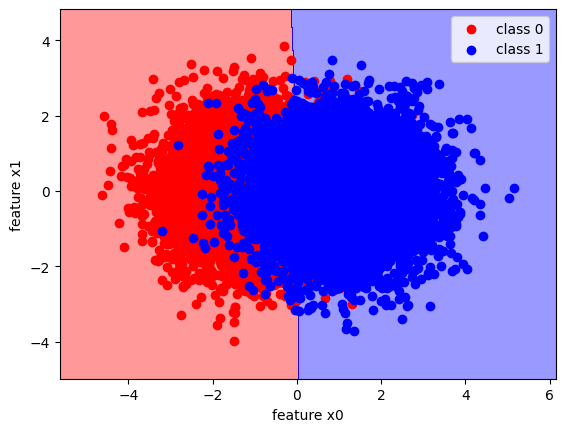

Estimated priors:  [0.5 0.5]
Estimated centroids (with MLE):  [[-1.01221402 -0.00434857]
 [ 1.00287205  0.00196621]]
Estimated covariances (with MLE):  [[[ 0.98313876 -0.01036178]
  [-0.01036178  0.9824378 ]]

 [[ 1.00518489 -0.01855164]
  [-0.01855164  0.98958793]]]
Test error (%):  15.58


In [ ]:
n_samples = [10000, 10000]
centroids = [[-1, 0],
             [1, 0]]
cov=[[[1, 0],
      [0, 1]],
     [[1, 0],
      [0, 1]]]

# generate data
x_tr, y_tr = make_gaussian_dataset(n_samples, centroids, cov=cov)
x_ts, y_ts = make_gaussian_dataset(n_samples, centroids, cov=cov)

clf = CClassifierGaussian()
clf.fit(x_tr, y_tr)
plot_decision_regions(x_tr, y_tr, classifier=clf)
plot_dataset(x_tr, y_tr)
plt.show()

scores = clf.decision_function(x_ts)
y_pred = clf.predict(x_ts)

print('Estimated priors: ', clf.priors)
print('Estimated centroids (with MLE): ', clf.centroids)
print('Estimated covariances (with MLE): ', clf.covariances)

print('Test error (%): ', (y_pred != y_ts).mean()*100)

